## User Behaviour on Twitter
Unsupervised clustering and interpreting.

In [1]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import  tqdm #NOT NEEDED, JUST USED WHEN WRITING THE NOTEBOOK
pd.set_option('display.max_columns', None)

In [2]:
#loading
egoalter = pd.read_csv('./EgoAlterProfiles.txt',delimiter='\t')
#egonet = pd.read_csv('./EgoNetworks.txt',delimiter='\t')
egotimes = pd.read_csv('./EgoTimelines.txt',delimiter='\t',encoding='latin-1')

In [4]:
# Apply the default theme
# sns.set_theme()

In [5]:
egoalter.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False


In [6]:
egotimes[200:400]

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID
200,NaN,NaN,605458456,523333693134622720,Sat Oct 18 04:44:10 +0000 2014,NaN,NaN,131556965,0,5,NaN,NaN,2423603
201,NaN,162670016.0,605458456,413801463979458560,Thu Dec 19 22:42:11 +0000 2013,NaN,NaN,"162670016,424891673,324662307",5,5,NaN,NaN,1792569
202,NaN,NaN,605458456,527763081762717696,Thu Oct 30 10:04:58 +0000 2014,IciCestParis,NaN,NaN,0,5,NaN,NaN,NaN
203,NaN,NaN,605458456,527719935527878656,Thu Oct 30 07:13:31 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
204,NaN,NaN,605458456,527252905972494338,Wed Oct 29 00:17:43 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,605458456,424146092771778560,Fri Jan 17 11:48:03 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
396,NaN,NaN,605458456,394447458828161025,Sun Oct 27 12:56:17 +0000 2013,skyrim,NaN,NaN,0,5,NaN,NaN,NaN
397,NaN,NaN,605458456,347778837368684544,Thu Jun 20 18:11:50 +0000 2013,NaN,http://t.co/n3Am0xdPgI,NaN,0,5,NaN,NaN,NaN
398,NaN,NaN,605458456,322070627999707136,Wed Apr 10 19:36:36 +0000 2013,BARCAPSG,NaN,NaN,0,5,NaN,NaN,NaN


### Features used for clustering
- followers count
- friends count
- followers-friends ratio
- proportion of tweets
- proportion of RT
- proportion of replies
- days since account creation
- average number of statuses per month
- average number of hashtags per post
- average number of URLs per post
- average number of mentions per post
- average number of retweets per tweet

In [7]:
def extract_info(df):
    
    n = len(df)
    n_replies = n - np.sum(df['replyto_userid'].isnull())
    n_rt = n - np.sum(df['retweeted_userid'].isnull())
    mentions = df[df['mentions_ids'].notnull()].mentions_ids
    n_mentions = len([x for xs in mentions for x in xs.split(',')])
    
    retweeted = np.nansum(df['retweet_count'])
    
    # number of hashtags
    hashtags = df[df['hashtags'].notnull()].hashtags
    n_hashtags = len([x for xs in hashtags for x in xs.split(',')])
    
    # number of urls per tweet
    urls = df[df['urls'].notnull()].urls
    n_urls = len([x for xs in urls for x in xs.split(',')])
    
    return n, n_replies, n_mentions, n_rt, n_hashtags, n_urls, retweeted

In [8]:
isEgo = egoalter.loc[egoalter['IsEgo']]

In [9]:
ego_intersect = set(egotimes['egoID'].unique()).intersection(set(isEgo['ID']))
columns = ['id','n_statuses', 'n_replies','n_mentions','n_rt','n_hashtags','n_urls','retweeted']
stats = pd.DataFrame(0, index=np.arange(len(ego_intersect)), columns=columns)

for i, _id in tqdm(enumerate(ego_intersect)):
    n, n_replies, n_mentions, n_rt, n_hashtags, n_urls, retweeted = extract_info(egotimes.loc[egotimes['egoID']==_id])
    stats.iloc[i].id = _id
    stats.iloc[i].n_statuses = n
    stats.iloc[i].n_replies = n_replies
    stats.iloc[i].n_mentions = n_mentions
    stats.iloc[i].n_rt = n_rt
    stats.iloc[i].n_hashtags = n_hashtags
    stats.iloc[i].n_urls = n_urls
    stats.iloc[i].retweeted = retweeted

17244it [03:22, 85.12it/s] 


In [10]:
merged = isEgo.merge(stats, how='left', left_on='ID', right_on='id')
merged.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected,id,n_statuses,n_replies,n_mentions,n_rt,n_hashtags,n_urls,retweeted
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False,1.0,9.0,4.0,8.0,0.0,0.0,0.0,0.0
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False,2.0,7.0,2.0,2.0,0.0,1.0,3.0,0.0
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False,4.0,68.0,0.0,0.0,0.0,0.0,60.0,0.0
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False,5.0,742.0,334.0,375.0,103.0,118.0,29.0,26408.0


In [11]:
inactive = (merged.friends_count == 0) & (merged.followers_count == 0)
merged['followers_ratio'] = (merged['followers_count']/(merged['friends_count'] + 0.01))
merged.loc[inactive,'followers_ratio'] = 1

merged['n_tweets'] = merged['n_statuses'] - merged['n_replies'] - merged['n_rt']
merged['prop_tweets'] = merged['n_tweets']/merged['n_statuses']
merged['prop_replies'] = merged['n_replies']/merged['n_statuses']
merged['prop_rt'] = merged['n_rt']/merged['n_statuses']
merged['avg_hashtags'] = merged['n_hashtags']/merged['n_statuses']
merged['avg_urls'] = merged['n_urls']/merged['n_statuses']
merged['avg_mentions'] = merged['n_mentions']/merged['n_statuses']
merged['avg_retweeted'] = (merged['retweeted']/merged['n_tweets']).replace(np.inf, 0)
merged['created_at'] = pd.to_datetime(merged['created_at'], format='%a %b %d %H:%M:%S %z %Y')
end_date = merged.created_at.max()
merged['account_age_months'] = ((end_date - merged.created_at).dt.days/30) + 0.01
merged['statuses_per_month'] = merged['statuses_count']/merged['account_age_months']
merged.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected,id,n_statuses,n_replies,n_mentions,n_rt,n_hashtags,n_urls,retweeted,followers_ratio,n_tweets,prop_tweets,prop_replies,prop_rt,avg_hashtags,avg_urls,avg_mentions,avg_retweeted,account_age_months,statuses_per_month
0,1,True,30.0,28,9.0,NaN,en,2011-10-26 03:30:32+00:00,False,1.0,9.0,4.0,8.0,0.0,0.0,0.0,0.0,1.071046,5.0,0.555556,0.444444,0.000000,0.000000,0.000000,0.888889,0.000000,36.676667,0.245388
1,2,True,2.0,8,7.0,-14400.0,en,2009-07-27 20:46:32+00:00,False,2.0,7.0,2.0,2.0,0.0,1.0,3.0,0.0,0.249688,5.0,0.714286,0.285714,0.000000,0.142857,0.428571,0.285714,0.000000,64.010000,0.109358
2,3,True,1.0,0,0.0,NaN,fr,2012-04-23 20:57:26+00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.643333,0.000000
3,4,True,3.0,3,68.0,NaN,en,2010-02-14 07:50:39+00:00,False,4.0,68.0,0.0,0.0,0.0,0.0,60.0,0.0,0.996678,68.0,1.000000,0.000000,0.000000,0.000000,0.882353,0.000000,0.000000,57.310000,1.186529
4,5,True,65.0,118,748.0,NaN,fr,2012-06-11 14:17:06+00:00,False,5.0,742.0,334.0,375.0,103.0,118.0,29.0,26408.0,0.550801,305.0,0.411051,0.450135,0.138814,0.159030,0.039084,0.505391,86.583607,29.010000,25.784212


In [12]:
cols = ['ID','followers_count','friends_count','statuses_count', 'account_age_months',
        'statuses_per_month','followers_ratio','prop_tweets', 'prop_replies','prop_rt',
        'avg_hashtags','avg_urls','avg_mentions']
features = merged[cols].fillna(0)

In [13]:
features.set_index('ID').describe()

,followers_count,friends_count,statuses_count,account_age_months,statuses_per_month,followers_ratio,prop_tweets,prop_replies,prop_rt,avg_hashtags,avg_urls,avg_mentions
count,34006.000000,34006.000000,3.400600e+04,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000
mean,56.604511,68.490061,4.483272e+02,26.648642,16.856397,39.142005,0.323153,0.115620,0.068313,0.094698,0.096359,0.249363
std,953.436514,344.940809,6.748816e+03,18.094187,174.167148,1879.330302,0.410767,0.245612,0.189213,0.330004,0.256844,0.448269
min,0.000000,0.000000,0.000000e+00,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000e+00,11.643333,0.000000,0.052604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,8.000000,1.000000e+00,23.876667,0.035150,0.363306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,37.000000,1.100000e+01,39.043333,0.671855,1.000000,0.727273,0.067467,0.000000,0.000000,0.001258,0.422831
max,124195.000000,24956.000000,1.082327e+06,104.476667,22893.471057,253800.000000,1.000000,1.000000,1.000000,12.000000,4.000000,8.500000


## Feature scaling and clustering

In [14]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.spatial.distance import cdist 
from sklearn import metrics 

In [15]:
#standardize values

standardize = preprocessing.StandardScaler()
std_df = standardize.fit_transform(features.iloc[:,1:])
std_df = pd.DataFrame(std_df, columns=features.iloc[:,1:].columns)

#de-standardize to get back original values

In [16]:
std_df

,followers_count,friends_count,statuses_count,account_age_months,statuses_per_month,followers_ratio,prop_tweets,prop_replies,prop_rt,avg_hashtags,avg_urls,avg_mentions
0,-0.027904,-0.117384,-0.065098,0.554221,-0.095375,-0.020258,0.565785,1.338813,-0.361044,-0.286965,-0.375169,1.426678
1,-0.057272,-0.175366,-0.065394,2.064857,-0.096156,-0.020695,0.952215,0.692540,-0.361044,0.145936,1.293462,0.081094
2,-0.058321,-0.198559,-0.066431,0.220775,-0.096784,0.032383,-0.786719,-0.470751,-0.361044,-0.286965,-0.375169,-0.556289
3,-0.056223,-0.189862,-0.056355,1.694567,-0.089972,-0.020298,1.647788,-0.470751,-0.361044,-0.286965,3.060248,-0.556289
4,0.008806,0.143534,0.044404,0.130506,0.051261,-0.020535,0.213988,1.361981,0.372604,0.194944,-0.222999,0.571156
...,...,...,...,...,...,...,...,...,...,...,...,...
34001,-0.059370,-0.198559,-0.066431,-1.002472,-0.096784,-0.020296,-0.786719,-0.470751,-0.361044,-0.286965,-0.375169,-0.556289
34002,0.144108,0.076855,-0.011606,-1.113006,0.229549,-0.019741,-0.296755,-0.445144,3.827161,0.827959,-0.338439,2.172629
34003,-0.059370,-0.198559,-0.066431,-0.691133,-0.096784,-0.020296,-0.786719,-0.470751,-0.361044,-0.286965,-0.375169,-0.556289
34004,-0.058321,-0.143476,-0.066431,-0.936151,-0.096784,-0.020800,-0.786719,-0.470751,-0.361044,-0.286965,-0.375169,-0.556289


In [17]:
distortions = [] 

X = std_df.copy()
K = range(1,10) 
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    dist_cluster = sum(np.min(cdist(std_df, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]
    distortions.append(dist_cluster) 

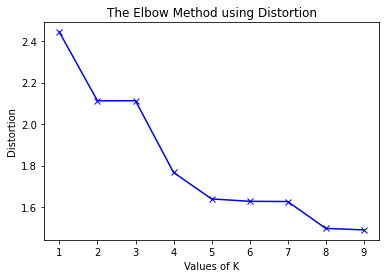

In [18]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [107]:
k = 8
kmeans = KMeans(n_clusters=k).fit(features.iloc[:,1:])
centroids = kmeans.cluster_centers_
# print(centroids)

In [108]:
#cluster representatives characteristics
pd.DataFrame(data={idx:point for idx,point in enumerate(centroids)},
            index=features.iloc[:,1:].columns)

,0,1,2,3,4,5,6,7
followers_count,6697.875000,35.898452,3.950000e+02,842.536364,2538.000000,1232.129870,948.000000,98227.000000
friends_count,3358.875000,59.703245,3.480000e+02,545.009091,0.000000,820.766234,0.000000,232.000000
statuses_count,123612.375000,131.489842,1.082327e+06,12031.825000,2547.000000,44372.402597,206.000000,29552.500000
account_age_months,49.843333,26.429059,4.727667e+01,39.718106,18.776667,44.332078,22.796667,55.976667
statuses_per_month,2708.311636,7.769686,2.289347e+04,411.010464,135.647080,1122.822414,13.760311,542.692523
followers_ratio,44.984537,17.855576,1.135025e+00,5.356522,253800.000000,2.458696,94800.000000,1346.993862
prop_tweets,0.474566,0.321118,8.646875e-01,0.446976,0.327700,0.463473,0.546019,0.304847
prop_replies,0.129887,0.114156,4.375000e-03,0.206304,0.056884,0.217594,0.253981,0.436963
prop_rt,0.145547,0.065981,1.309375e-01,0.214902,0.615416,0.228023,0.000000,0.258189
avg_hashtags,0.075983,0.093551,1.943750e-01,0.170585,0.071723,0.139231,0.426971,0.094512


In [127]:
idx = []
for c in range(k):
    idx.append([i for i, x in enumerate(kmeans.labels_) if x == c])

In [128]:
for i in range(k):
    print(len(idx[i]))

8
33471
1
441
1
77
5
2


In [335]:
colors = ['red','black','blue','green','yellow', 'pink', 'magenta', 'cyan', 'grey', 'lightgreen']
LABEL_COLOR_MAP = {0:'r', 1:'k', 2:'b', 3:'g', 4:'y', 5:'pink', 6:'m',7:'c', 8:'grey', 9:'lightgreen'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

#orthogonal projection, onto space spanned by two
def plot_project1d(I,features,centroids=None):
    #idx(i) globally defined
    fig, axs = plt.subplots(4,3,figsize=(15,15))
    
    for index, i in enumerate(I):
        m,s = index%4, index//4
        for c in range(k):
            try:
                features.iloc[idx[c],i].plot.kde(label=c, ax=axs[m,s], c=colors[c])
            except:
                axs[m,s].axvline(features.iloc[idx[c],i].median(), 0,1, label=c, c=colors[c])
        axs[m,s].legend()
        axs[m,s].set_yscale('symlog')
        axs[m,s].set_xscale('symlog')
        axs[m,s].set_ylim([0, 1])
        axs[m,s].title.set_text('{}'.format(features.columns[index]))
    fig.tight_layout()
    
def plot_project2d(pairs,features,centroids):
    fig, axs = plt.subplots(4,3,figsize=(15,15))
    count = 0
    for i,j in zip(pairs[0],pairs[1]):
        m,s = count%4, count//4
        for g in np.unique(kmeans.labels_):
            if g != 7:
                axs[m,s].scatter(centroids[g, i], centroids[g, j], c=colors[g], label=g, s=100)
        #axs[m,s].scatter(features.iloc[:,i], features.iloc[:,j], marker = 'x', c=label_color, s=20, alpha=0.30)
        axs[m,s].legend()
        axs[m,s].title.set_text('{} vs {}'.format(features.columns[i],features.columns[j]))
        count += 1
        
    fig.tight_layout()

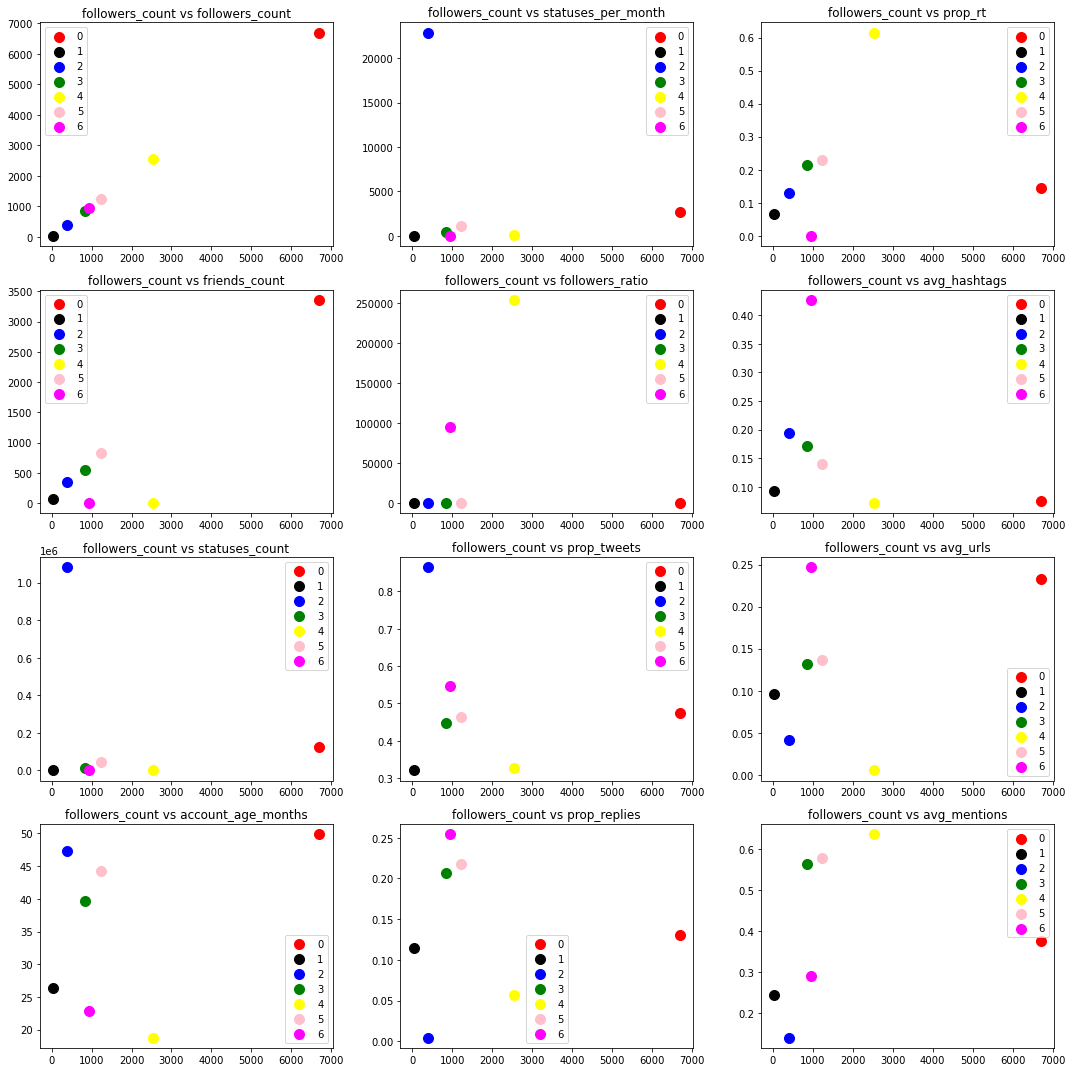

In [336]:
pairs = np.transpose([[0,i] for i in range(12)])
plot_project2d(pairs, std_df, centroids)

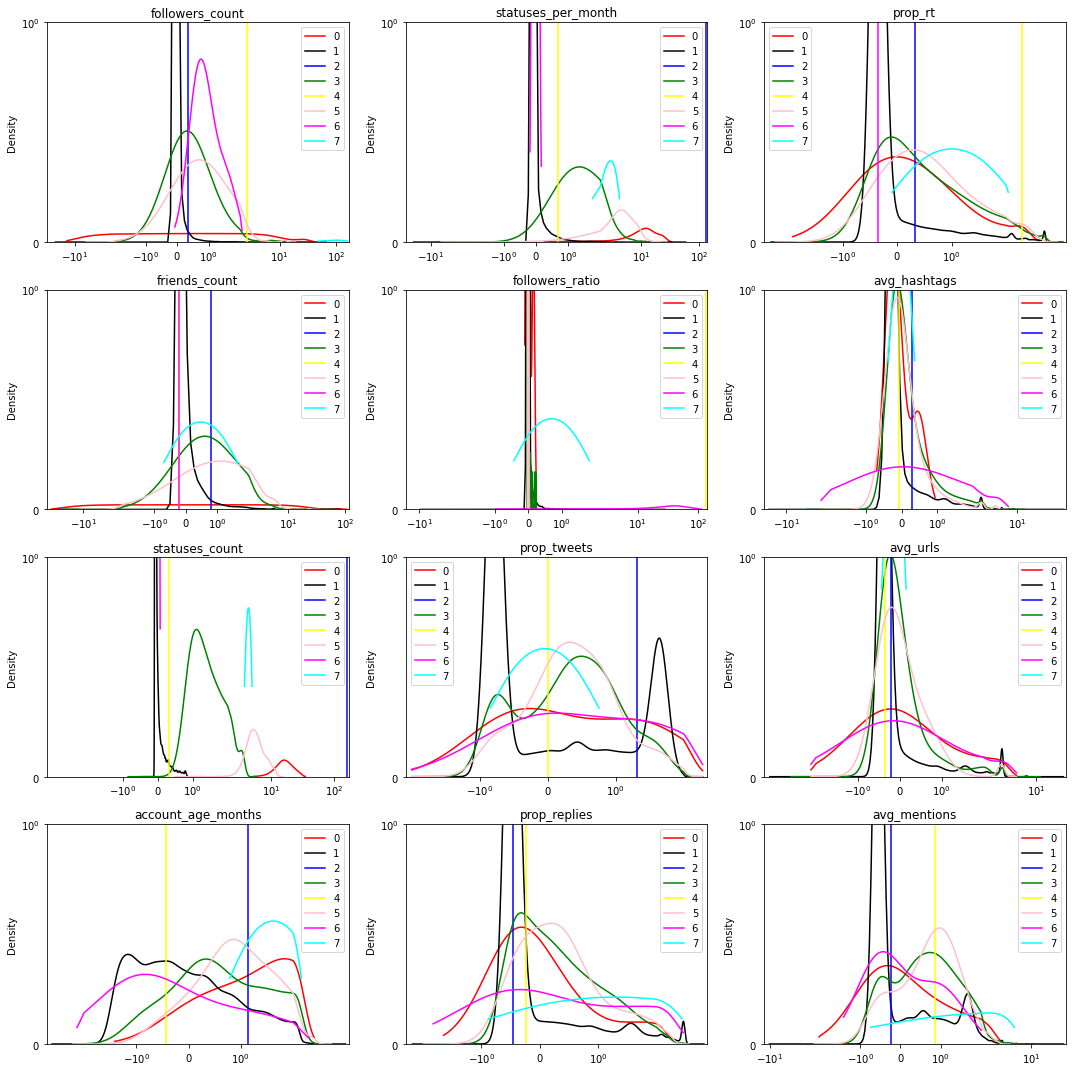

In [337]:
plot_project1d(list(range(12)), std_df, centroids)

## Interactive plots

In [236]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import chart_studio.plotly as py
init_notebook_mode(connected=True)

In [257]:
cluster_list = np.arange(k)
feature_names = features.columns.tolist()[1:]
centres = pd.DataFrame(centroids, columns=feature_names)

In [341]:
fig = go.Figure(go.Scatter(x=centres['followers_count'], 
                           y=centres['friends_count'], 
                           mode='markers', marker_size=15, 
                           marker_color = colors[:len(centres)] ))

buttons_x = [dict(method = "restyle",
                   args = [{'y': [ centres[feature_names[c]] ]}],
                   label = feature_names[c]) for c in range(len(feature_names))]
buttons_y = [dict(method = "restyle",
                   args = [{'x': [ centres[feature_names[c]] ]}],
                   label = feature_names[c]) for c in range(len(feature_names))]

fig.update_layout(width=800, height=400,
                 updatemenus=[dict(active=0,
                                   x= 1.1, y=1, 
                                   xanchor='left', 
                                   yanchor='top',
                                   buttons=buttons_x),
                              
                               dict(active=0,
                                   x= 1.1, y=0.8, 
                                   xanchor='left', 
                                   yanchor='top',
                                   buttons=buttons_y)
                              ])  
iplot(fig)